# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

2023-07-05 00:43:07.736834: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 00:43:07.802521: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 00:43:08.115142: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 00:43:08.116216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 00:43:09.769363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Carrega Dados

In [ ]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(3349, 4)

<AxesSubplot: ylabel='Date'>

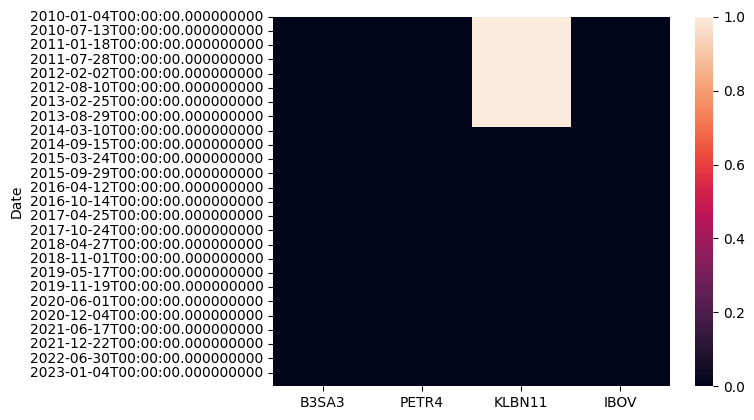

In [ ]:
sns.heatmap(acoes_df.isnull())

In [ ]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,3.250000,15.470000,11.744000,48321.0
2014-01-24,3.233333,15.100000,11.744000,47787.0
2014-01-27,3.300000,15.110000,11.744000,47701.0
2014-01-28,3.280000,15.050000,12.586000,47841.0
2014-01-29,3.170000,14.800000,12.350000,47557.0
...,...,...,...,...
2023-06-28,13.950000,30.889999,21.709999,116681.0
2023-06-29,14.640000,31.030001,21.570000,118383.0
2023-06-30,14.610000,29.530001,21.770000,118087.0


### Visualização dos dados 

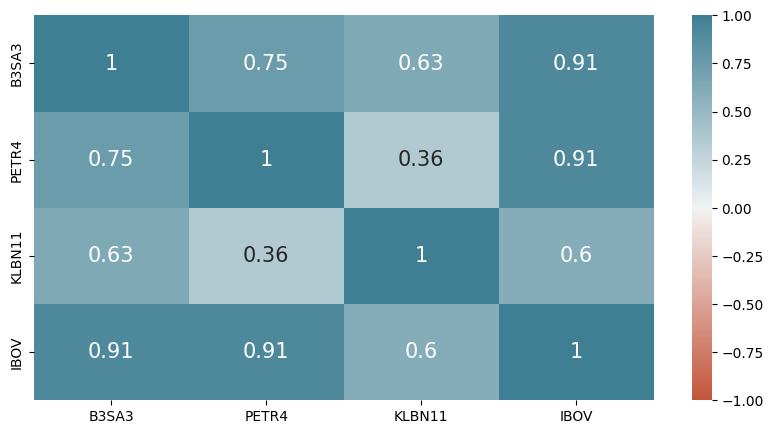

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [ ]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [ ]:
acoes_df_normalized

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,1.000000,1.000000,1.000000,1.000000
2014-01-24,0.994872,0.976083,1.000000,0.988949
2014-01-27,1.015385,0.976729,1.000000,0.987169
2014-01-28,1.009231,0.972851,1.071696,0.990066
2014-01-29,0.975385,0.956690,1.051601,0.984189
...,...,...,...,...
2023-06-28,4.292308,1.996768,1.848603,2.414706
2023-06-29,4.504615,2.005818,1.836682,2.449929
2023-06-30,4.495385,1.908856,1.853713,2.443803


In [ ]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [ ]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [ ]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [ ]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [ ]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')

# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()

# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))

if ticker=="^BVSP":
    ticker='IBOV'
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


[*********************100%***********************]  1 of 1 completed


In [ ]:
df.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
               '2023-07-03', '2023-07-04'],
              dtype='datetime64[ns]', name='Date', length=2106, freq=None)

In [ ]:
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variacao'] = ((df['Close'].shift(-7) - df['Close']) / df['Close'])*100

# Definir a variável alvo com base na variação percentual
df['Subida'] = df['Variacao'].apply(lambda x: 1 if x > 1 else 0)

df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df

/tmp/ipykernel_534570/1250799132.py:7: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



,Date,Open,High,Low,Close,Adj Close,Volume,EMA9,EMA20,EMA50,EMA100,EMA200,Variacao,Subida,week,weekday,day,month,quarter
0,2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100,48512.000000,48512.000000,48512.000000,48512.000000,48512.000000,-0.968832,0,1,5,2,1,1
1,2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100,47959.222222,47989.625000,48004.550000,48009.525000,48012.012500,0.271482,0,2,1,5,1,1
2,2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300,47976.344262,47993.801832,48003.319024,48006.626312,48008.304897,0.052082,0,2,2,6,1,1
3,2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800,48479.953930,48417.936627,48390.420466,48381.714620,48377.451872,-0.901684,0,2,3,7,1,1
4,2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900,48915.177059,48786.836479,48726.264184,48706.585611,48696.854843,-4.374987,0,2,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2023-06-28,117524.0,117937.0,116560.0,116681.0,116681.0,10646300,117976.808933,116444.754379,112457.878145,110103.453004,109303.519649,0.000000,0,26,3,28,6,2
2102,2023-06-29,116683.0,118623.0,116683.0,118383.0,118383.0,11055300,118058.047146,116629.349200,112690.235865,110267.404429,109393.862737,0.000000,0,26,4,29,6,2
2103,2023-06-30,118388.0,119447.0,118087.0,118087.0,118087.0,0,118063.837717,116768.173086,112901.873674,110422.247906,109480.361616,0.000000,0,26,5,30,6,2
2104,2023-07-03,118092.0,119877.0,118092.0,119673.0,119673.0,8907500,118385.670174,117044.823268,113167.408040,110605.431116,109581.780903,0.000000,0,27,1,3,7,3


### Pré-processamento dos dados para predição 

In [ ]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
ticker='IBOV'
acoes_df = acoes_df[['Date', 'IBOV']]
acoes_df.columns = ['ds', 'y']

In [ ]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [ ]:
lookback = 15  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        X += [data[win-lookback:win]]
        y += [data[win:win+pred_days]]  
    X=np.array(X)
    y=np.array(y)
    return X, y

X, y = windowing(acoes_df_norm['y'].values)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2323, 15)
y shape (2323, 1)
Last Date 2023-07-04T00:00:00.000000000


In [ ]:
# separa os dados em Treino e Teste
def split_data(X,y,date_time,factor=0.70):
    nits=round(len(X)*factor)
    X_train=X[:nits,:]
    X_test=X[nits:,:]

    y_train=y[:nits]
    y_test =y[nits:]
    
    T_train=date_time[:nits]
    T_test =date_time[nits:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.70)

In [ ]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train, y=np.hstack(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.hstack(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

### Modelo de rede neural

In [ ]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform
model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    #model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model=dense_layers(features, n_outputs = pred_days)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             384       
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 32)                12320     
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
 activation_1 (Activation)   (None, 1)                 0

In [ ]:
'''model_name= "MLP"
# Camada de entrada
input_data = Input(shape=(X.shape[1],))

dense_output = Dense(64, activation='relu')(input_data)
#dense_output=Dropout(0.2)(dense_output)

dense_output = Dense(128, activation='relu')(dense_output)
dense_output=Dropout(0.2)(dense_output)

#dense_output = Dense(10, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

# Camada de saída
output = Dense(1, activation='linear')(dense_output)


model = Model(inputs=input_data, outputs=output)
model.summary()'''

'model_name= "MLP"\n# Camada de entrada\ninput_data = Input(shape=(X.shape[1],))\n\ndense_output = Dense(64, activation=\'relu\')(input_data)\n#dense_output=Dropout(0.2)(dense_output)\n\ndense_output = Dense(128, activation=\'relu\')(dense_output)\ndense_output=Dropout(0.2)(dense_output)\n\n#dense_output = Dense(10, activation=\'relu\')(dense_output)\n#dense_output=Dropout(0.5)(dense_output)\n\n# Camada de saída\noutput = Dense(1, activation=\'linear\')(dense_output)\n\n\nmodel = Model(inputs=input_data, outputs=output)\nmodel.summary()'

In [ ]:
'''model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output = LSTM(64, activation='relu', return_sequences=False)(input_data)

lstm_output=Dropout(0.2)(lstm_output)
#dense_output = Dense(128, activation='relu')(dense_output)
#dense_output=Dropout(0.2)(dense_output)

# Camada de saída
output = Dense(pred_days, activation='linear')(lstm_output)

model = Model(inputs=input_data, outputs=output)
model.summary()'''

'model_name= "LSTM"\n# Camada de entrada\ninput_data = Input(shape=(X.shape[1],1))\n\n# Camada LSTM\nlstm_output = LSTM(64, activation=\'relu\', return_sequences=False)(input_data)\n\nlstm_output=Dropout(0.2)(lstm_output)\n#dense_output = Dense(128, activation=\'relu\')(dense_output)\n#dense_output=Dropout(0.2)(dense_output)\n\n# Camada de saída\noutput = Dense(pred_days, activation=\'linear\')(lstm_output)\n\nmodel = Model(inputs=input_data, outputs=output)\nmodel.summary()'

In [ ]:
'''model_name= "GRU
from tensorflow.keras.layers import GRU, Dense

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(pred_days, activation='linear'))

model.summary()'''

'model_name= "GRU\nfrom tensorflow.keras.layers import GRU, Dense\n\nmodel = Sequential()\nmodel.add(GRU(64, input_shape=(X.shape[1], 1)))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(pred_days, activation=\'linear\'))\n\nmodel.summary()'

In [ ]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)
checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'

csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)

print("Training model :", checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)

optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
model.compile(loss='mse', optimizer=optimizer1,metrics=[NRMSE])
history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])
#history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

Training model : models/CNN_LSTM_IBOV_15_ex1
Epoch 1/200
35/36 [============================>.] - ETA: 0s - loss: 3.5318 - NRMSE: 0.4416 
Epoch 1: val_loss improved from inf to 0.16481, saving model to models/CNN_LSTM_IBOV_15_ex1


2023-07-05 00:43:17.802577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:17.957492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 23ms/step - loss: 3.4761 - NRMSE: 0.4545 - val_loss: 0.1648 - val_NRMSE: 0.6122 - lr: 0.0500
Epoch 2/200
33/36 [==========================>...] - ETA: 0s - loss: 0.0055 - NRMSE: 0.9285
Epoch 2: val_loss improved from 0.16481 to 0.01084, saving model to models/CNN_LSTM_IBOV_15_ex1


2023-07-05 00:43:18.460217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:18.582234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 17ms/step - loss: 0.0053 - NRMSE: 0.9294 - val_loss: 0.0108 - val_NRMSE: 0.9065 - lr: 0.0500
Epoch 3/200
33/36 [==========================>...] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9448
Epoch 3: val_loss improved from 0.01084 to 0.00725, saving model to models/CNN_LSTM_IBOV_15_ex1


2023-07-05 00:43:19.045531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:19.170827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 17ms/step - loss: 0.0031 - NRMSE: 0.9458 - val_loss: 0.0073 - val_NRMSE: 0.9273 - lr: 0.0500
Epoch 4/200
31/36 [========================>.....] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9535
Epoch 4: val_loss improved from 0.00725 to 0.00410, saving model to models/CNN_LSTM_IBOV_15_ex1


2023-07-05 00:43:19.644935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:19.775371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 21ms/step - loss: 0.0023 - NRMSE: 0.9528 - val_loss: 0.0041 - val_NRMSE: 0.9489 - lr: 0.0500
Epoch 5/200
33/36 [==========================>...] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9549
Epoch 5: val_loss did not improve from 0.00410
36/36 [==============================] - 0s 3ms/step - loss: 0.0021 - NRMSE: 0.9548 - val_loss: 0.0052 - val_NRMSE: 0.9392 - lr: 0.0500
Epoch 6/200
34/36 [===========================>..] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9582
Epoch 6: val_loss improved from 0.00410 to 0.00219, saving model to models/CNN_LSTM_IBOV_15_ex1


2023-07-05 00:43:20.491654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:20.605795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 15ms/step - loss: 0.0018 - NRMSE: 0.9585 - val_loss: 0.0022 - val_NRMSE: 0.9656 - lr: 0.0500
Epoch 7/200
34/36 [===========================>..] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9594
Epoch 7: val_loss did not improve from 0.00219
36/36 [==============================] - 0s 3ms/step - loss: 0.0017 - NRMSE: 0.9597 - val_loss: 0.0036 - val_NRMSE: 0.9513 - lr: 0.0500
Epoch 8/200
34/36 [===========================>..] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9605
Epoch 8: val_loss did not improve from 0.00219
36/36 [==============================] - 0s 3ms/step - loss: 0.0016 - NRMSE: 0.9608 - val_loss: 0.0092 - val_NRMSE: 0.9119 - lr: 0.0500
Epoch 9/200
35/36 [============================>.] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9591
Epoch 9: val_loss improved from 0.00219 to 0.00188, saving model to models/CNN_LSTM_IBOV_15_ex1


2023-07-05 00:43:21.238408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:21.351973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 16ms/step - loss: 0.0017 - NRMSE: 0.9591 - val_loss: 0.0019 - val_NRMSE: 0.9679 - lr: 0.0500
Epoch 10/200
29/36 [=======================>......] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9626
Epoch 10: val_loss did not improve from 0.00188
36/36 [==============================] - 0s 4ms/step - loss: 0.0014 - NRMSE: 0.9624 - val_loss: 0.0054 - val_NRMSE: 0.9277 - lr: 0.0500
Epoch 11/200
23/36 [==================>...........] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9635
Epoch 11: val_loss did not improve from 0.00188
36/36 [==============================] - 0s 3ms/step - loss: 0.0013 - NRMSE: 0.9652 - val_loss: 0.0025 - val_NRMSE: 0.9620 - lr: 0.0500
Epoch 12/200
30/36 [========================>.....] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9664
Epoch 12: val_loss did not improve from 0.00188
36/36 [==============================] - 0s 3ms/step - loss: 0.0012 - NRMSE: 0.9657 - val_loss: 0.0021 - val_NRMSE: 0.9666 - lr: 0.0500
Epoch 13/200
32/36 [============

2023-07-05 00:43:22.255868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:22.374253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 16ms/step - loss: 0.0013 - NRMSE: 0.9648 - val_loss: 0.0016 - val_NRMSE: 0.9704 - lr: 0.0500
Epoch 15/200
24/36 [===================>..........] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9657
Epoch 15: val_loss did not improve from 0.00164
36/36 [==============================] - 0s 3ms/step - loss: 0.0011 - NRMSE: 0.9671 - val_loss: 0.0021 - val_NRMSE: 0.9597 - lr: 0.0500
Epoch 16/200
26/36 [====================>.........] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9647    
Epoch 16: val_loss did not improve from 0.00164
36/36 [==============================] - 0s 3ms/step - loss: 0.0012 - NRMSE: 0.9662 - val_loss: 0.0017 - val_NRMSE: 0.9710 - lr: 0.0500
Epoch 17/200
28/36 [======================>.......] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9660
Epoch 17: val_loss did not improve from 0.00164
36/36 [==============================] - 0s 3ms/step - loss: 0.0012 - NRMSE: 0.9651 - val_loss: 0.0063 - val_NRMSE: 0.9221 - lr: 0.0500
Epoch 18/200
31/36 [========

2023-07-05 00:43:23.661479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:23.772708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 16ms/step - loss: 0.0010 - NRMSE: 0.9688 - val_loss: 0.0016 - val_NRMSE: 0.9712 - lr: 0.0100
Epoch 24/200
24/36 [===================>..........] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9678    
Epoch 24: val_loss did not improve from 0.00159

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
36/36 [==============================] - 0s 3ms/step - loss: 0.0011 - NRMSE: 0.9676 - val_loss: 0.0025 - val_NRMSE: 0.9545 - lr: 0.0100
Epoch 25/200
29/36 [=======================>......] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9683
Epoch 25: val_loss did not improve from 0.00159
36/36 [==============================] - 0s 3ms/step - loss: 0.0010 - NRMSE: 0.9688 - val_loss: 0.0016 - val_NRMSE: 0.9699 - lr: 0.0020
Epoch 26/200
31/36 [========================>.....] - ETA: 0s - loss: 9.9721e-04 - NRMSE: 0.9688
Epoch 26: val_loss did not improve from 0.00159
36/36 [==============================] - 0s 3ms/step - loss: 9.9731e-04 - NRMSE: 0

2023-07-05 00:43:24.653355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]
2023-07-05 00:43:24.767881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_IBOV_15_ex1/assets


36/36 [==============================] - 1s 15ms/step - loss: 9.8797e-04 - NRMSE: 0.9688 - val_loss: 0.0016 - val_NRMSE: 0.9706 - lr: 0.0020
Epoch 29/200
33/36 [==========================>...] - ETA: 0s - loss: 9.2269e-04 - NRMSE: 0.9702
Epoch 29: val_loss did not improve from 0.00159

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
36/36 [==============================] - 0s 3ms/step - loss: 9.2042e-04 - NRMSE: 0.9701 - val_loss: 0.0016 - val_NRMSE: 0.9713 - lr: 0.0020
Epoch 30/200
24/36 [===================>..........] - ETA: 0s - loss: 9.3224e-04 - NRMSE: 0.9697
Epoch 30: val_loss did not improve from 0.00159
36/36 [==============================] - 0s 3ms/step - loss: 9.5283e-04 - NRMSE: 0.9695 - val_loss: 0.0016 - val_NRMSE: 0.9712 - lr: 4.0000e-04
Epoch 31/200
34/36 [===========================>..] - ETA: 0s - loss: 9.9490e-04 - NRMSE: 0.9689
Epoch 31: val_loss did not improve from 0.00159
36/36 [==============================] - 0s 2ms/step - loss: 0

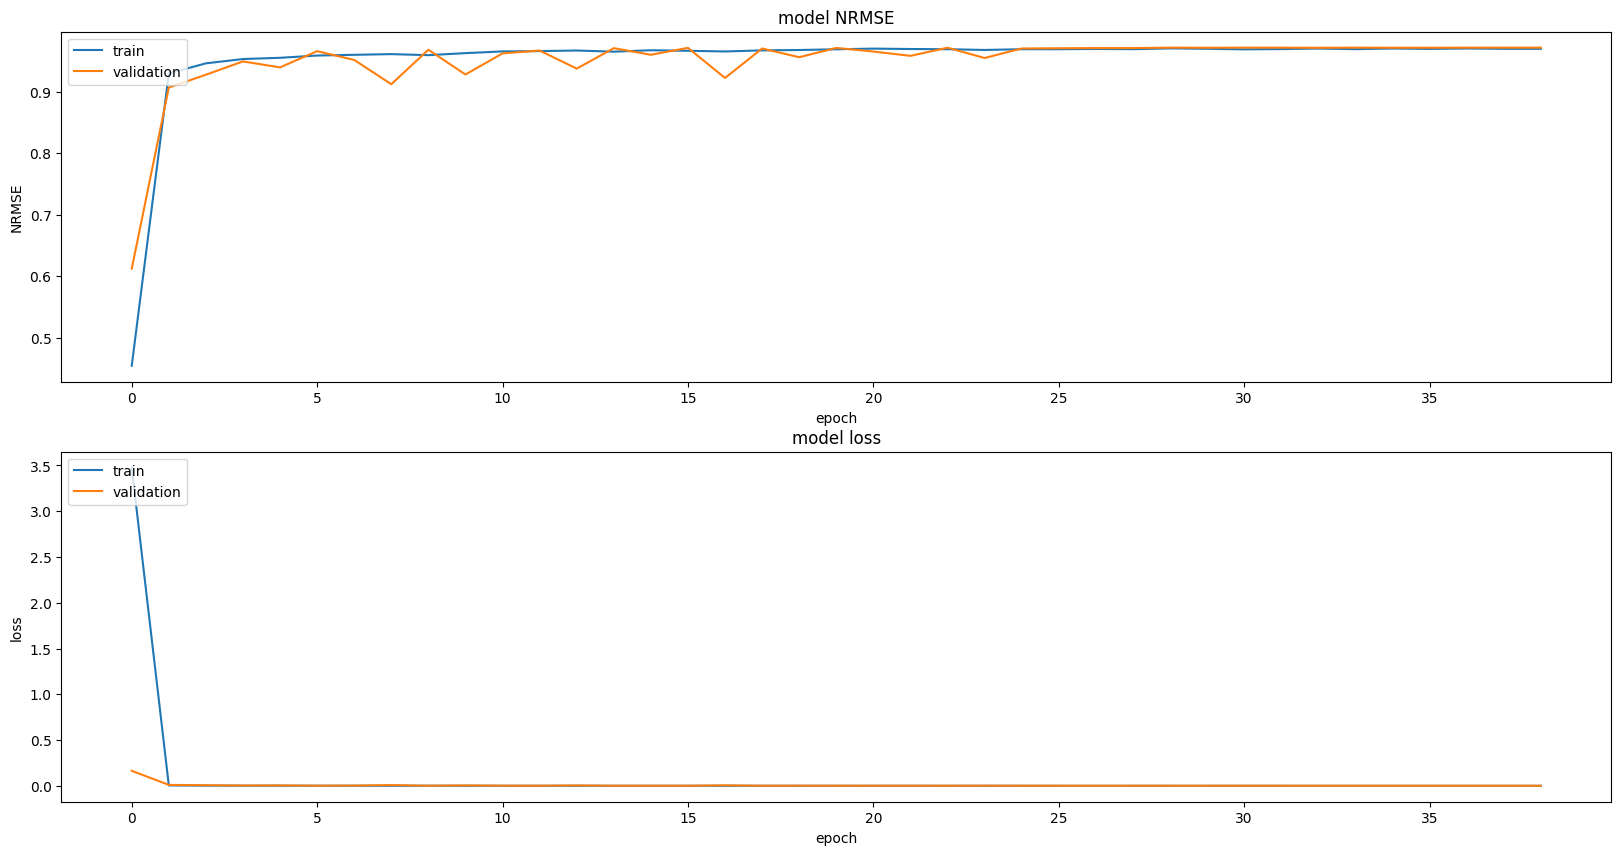

In [ ]:
plt.figure(1,figsize=(20,10))  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['NRMSE']) 
plt.plot(history.history['val_NRMSE'])  
plt.title('model NRMSE')  
plt.ylabel('NRMSE')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left') 
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])   
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  

In [ ]:
from tensorflow import keras
model=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [ ]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(acoes_df['y'].values)
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.70)

y_pred=scaler.inverse_transform(model.predict(X_test))
r2_score= R2(y_test_real, y_pred )
print('NN R2:', r2_score)

22/22 [==============================] - 0s 963us/step
NN R2: 0.8658779859542847


In [ ]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
fig.add_trace(go.Scatter(x=T_test, y=y_pred, mode='lines', name='Valor Predito', line=dict(color='blue')))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Geração de valores para predições futuras

In [ ]:
dias_antes=4
n_steps=5

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2023-07-04
Estamos Fornecendo dados até o dia : 2023-06-30
O modelo fará previsões até o dia:  2023-07-05


In [ ]:
# processo interativo para predição com o modelo de rede neural
dias_antes=4
n_steps=5

y_outs=y_test[:-dias_antes].copy()
X_inputs=X_test[:-dias_antes,:].copy()
T_preds=T_test.values[:-dias_antes].copy()

for k in range(n_steps):
    y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))
    y_outs=np.append(y_outs,[y_pred[0][0]])
    X_inputs=np.append(X_inputs,y_outs[-lookback:].reshape(1,-1),axis=0)
    aux=T_preds[-1]+np.timedelta64(1,'D')
    T_preds=np.append(T_preds,aux)
    
y_outs=scaler.inverse_transform(y_outs.reshape(-1,1))
y_outs=np.hstack(y_outs)

1/1 [==============================] - 0s 23ms/step


In [ ]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])
model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
model_arima_fit = model_arima.fit()

arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
arima_predictions.shape

/home/bruno.dutra/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/bruno.dutra/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/bruno.dutra/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(6,)

In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores preditos ao gráfico
fig.add_trace(go.Scatter(x=T_preds, y=y_outs, mode='lines', name=f'Predicted {model_name}', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [ ]:
pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': y_outs})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(-1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.2 else 0)
pred_data_df.tail(10)

,Data,pred,Variacao,Subida
688,2023-06-22,118934.000000,-0.036155,0
689,2023-06-23,118977.000000,0.616926,1
690,2023-06-26,118243.000000,0.608922,1
691,2023-06-27,117522.992188,0.716449,1
692,2023-06-28,116681.000000,-2.657606,0
693,2023-06-29,119781.921875,0.362449,1
694,2023-06-30,119347.773438,-0.360004,0
695,2023-07-01,119777.429688,0.063353,0
696,2023-07-02,119701.546875,-0.190996,0
697,2023-07-03,119930.171875,NaN,0


In [ ]:
result=pred_data_df.iloc[-2:-1,:]
result

,Data,pred,Variacao,Subida
696,2023-07-02,119701.546875,-0.190996,0


In [ ]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )


A previsão para o dia 2023-07-02 é de Descida, de -0.1899999976158142% o valor predito é de: 119701.55
